C: 0.5882352941176471, Gc: 0.4411764705882353, Bc: 0.3235294117647059, P: 1.0, Ro: 0.12849162011173185


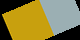

In [734]:
from random import *
from PIL import Image
import requests

r1 = randint(0, 255)
g1 = randint(0, 255)
b1 = randint(0, 255)
r2 = randint(0, 255)
g2 = randint(0, 255)
b2 = randint(0, 255)
p = randint(-7, 7)
r = randint(0, 179)
ow = 40
w = 20

img1 = Image.new("RGB", (ow, ow), (r1, g1, b1))
img2 = Image.new("RGB", (ow, ow), (r2, g2, b2))
nw = 2*ow
nh = ow
img = Image.new("RGB", (nw, nh))
img.paste(img1, (p, 0))
img.paste(img2, (ow+p, 0))
img = img.rotate(r, resample=Image.Resampling.BICUBIC)
# img = img.rotate(r)

left = (nw - w)/2
top = (nh - w)/2
right = (nw + w)/2
bottom = (nh + w)/2

o = img.crop((left, top, right, bottom))
c = (3*r1-3*r2 + 765) / 1530
gc = ((g1-r1) - (g2 -r2) + 510) / 1020
bc = ((2*b1 - r1 - g1) -(2*b2 - r2 - g2)  + 1020) / 2040
P = (p+7)/14
Ro = r / 179
print(f'C: {c}, Gc: {gc}, Bc: {bc}, P: {P}, Ro: {Ro}')
img

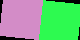

In [575]:
img

In [22]:
from datasets import load_dataset
ds = load_dataset('keylazy/cortical_data').with_format('torch')

tensor([[[[184, 184, 184,  ..., 213, 213, 213],
          [184, 184, 184,  ..., 213, 213, 213],
          [184, 184, 184,  ..., 213, 213, 213],
          ...,
          [184, 184, 184,  ..., 213, 213, 213],
          [184, 184, 184,  ..., 213, 213, 213],
          [184, 184, 183,  ..., 213, 213, 213]],

         [[ 45,  45,  45,  ...,  44,  44,  44],
          [ 45,  45,  45,  ...,  44,  44,  44],
          [ 45,  45,  45,  ...,  44,  44,  44],
          ...,
          [ 45,  45,  45,  ...,  44,  44,  44],
          [ 45,  45,  45,  ...,  44,  44,  44],
          [ 45,  45,  45,  ...,  44,  44,  44]],

         [[ 27,  27,  27,  ..., 191, 191, 191],
          [ 27,  27,  27,  ..., 191, 191, 191],
          [ 27,  27,  27,  ..., 191, 191, 191],
          ...,
          [ 27,  27,  27,  ..., 191, 191, 191],
          [ 27,  27,  27,  ..., 191, 191, 191],
          [ 27,  27,  25,  ..., 191, 191, 191]]],


        [[[ 79,  79,  79,  ...,  79,  78,  56],
          [ 79,  79,  79,  ...,  81

In [42]:
ds = ds.with_format('torch')
t = ds['train'][0]['image'].reshape((-1, 3*20*20)).shape
t

torch.Size([1, 1200])

In [7]:
%load_ext autoreload
%autoreload 2

In [2]:
from NNModel import get_model, val_loss, train_batch
from data import get_data
import numpy as np
device = 'cpu'

/Users/zanqiliang/cv/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tr_dl, val_dl = get_data(device, flatten=True)
model, loss_fn, optimizer = get_model(device)

Map: 100%|██████████| 5000/5000 [00:00<00:00, 6251.33 examples/s]


In [4]:
train_losses = []
val_losses = []
epochs = np.arange(30)+1
for epoch in epochs:
    print(epoch)
    train_epoch_losses = []
    for ix, batch in enumerate(iter(tr_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        validation_loss = val_loss(x, y, model, loss_fn)

    train_losses.append(train_epoch_loss)
    val_losses.append(validation_loss)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


In [5]:
from torchsummary import summary

summary(model, next(iter(tr_dl))[0])


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1000]                1,201,000
├─ReLU: 1-2                              [-1, 1000]                --
├─Linear: 1-3                            [-1, 5]                   5,005
Total params: 1,206,005
Trainable params: 1,206,005
Non-trainable params: 0
Total mult-adds (M): 1.21
Input size (MB): 0.15
Forward/backward pass size (MB): 0.01
Params size (MB): 4.60
Estimated Total Size (MB): 4.75


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 1000]                1,201,000
├─ReLU: 1-2                              [-1, 1000]                --
├─Linear: 1-3                            [-1, 5]                   5,005
Total params: 1,206,005
Trainable params: 1,206,005
Non-trainable params: 0
Total mult-adds (M): 1.21
Input size (MB): 0.15
Forward/backward pass size (MB): 0.01
Params size (MB): 4.60
Estimated Total Size (MB): 4.75

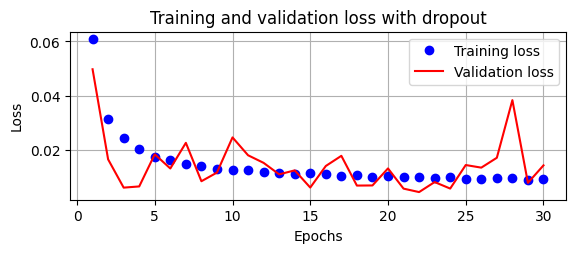

In [6]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with dropout')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.show()

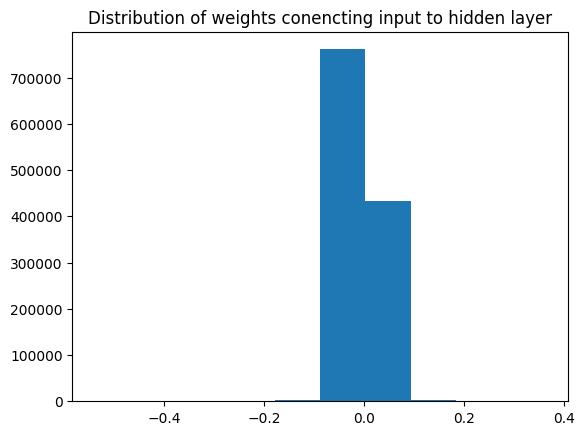

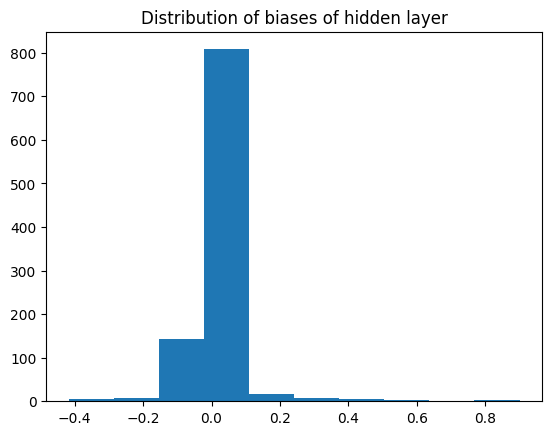

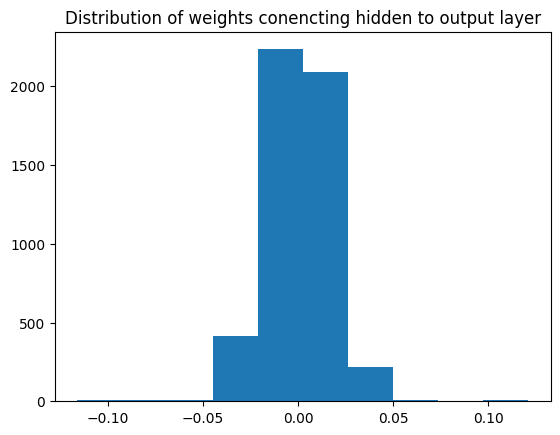

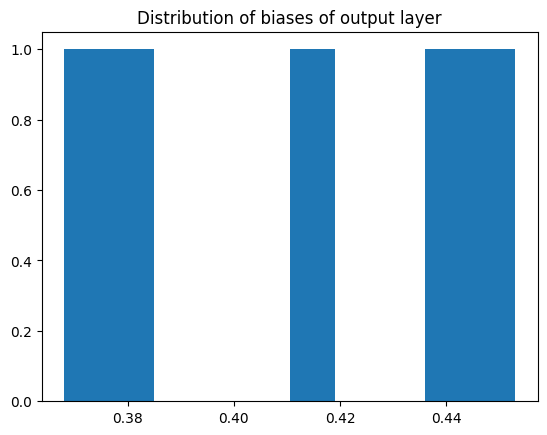

In [7]:
for ix, par in enumerate(model.parameters()):
  if(ix==0):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of weights conencting input to hidden layer')
      plt.show()
  elif(ix ==1):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of biases of hidden layer')
      plt.show()
  elif(ix==2):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of weights conencting hidden to output layer')
      plt.show()
  elif(ix ==3):
      plt.hist(par.cpu().detach().numpy().flatten())
      #plt.xlim(-2,2)
      plt.title('Distribution of biases of output layer')
      plt.show()  

In [8]:
t = np.array([[1, 2], [3, 4]])
np.roll(t, 1, axis=1)

array([[2, 1],
       [4, 3]])

In [1]:
device = 'mps'

In [5]:
from CNNModel import get_model, train_batch, val_loss
from data import get_data
import numpy as np
from torchsummary import summary

tr_dl, val_dl = get_data(flatten=False)
model, loss_fn, optimizer = get_model(device)

In [3]:
summary(model, next(iter(tr_dl))[0])

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 10, 10]          --
|    └─Conv2d: 2-1                       [-1, 64, 20, 20]          1,792
|    └─ReLU: 2-2                         [-1, 64, 20, 20]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 10, 10]          --
├─Sequential: 1-2                        [-1, 256, 5, 5]           --
|    └─Conv2d: 2-4                       [-1, 256, 10, 10]         147,712
|    └─ReLU: 2-5                         [-1, 256, 10, 10]         --
|    └─MaxPool2d: 2-6                    [-1, 256, 5, 5]           --
├─Sequential: 1-3                        [-1, 256, 2, 2]           --
|    └─Conv2d: 2-7                       [-1, 256, 5, 5]           590,080
|    └─ReLU: 2-8                         [-1, 256, 5, 5]           --
|    └─MaxPool2d: 2-9                    [-1, 256, 2, 2]           --
├─Sequential: 1-4                        [-1, 256, 1, 1]           --
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 10, 10]          --
|    └─Conv2d: 2-1                       [-1, 64, 20, 20]          1,792
|    └─ReLU: 2-2                         [-1, 64, 20, 20]          --
|    └─MaxPool2d: 2-3                    [-1, 64, 10, 10]          --
├─Sequential: 1-2                        [-1, 256, 5, 5]           --
|    └─Conv2d: 2-4                       [-1, 256, 10, 10]         147,712
|    └─ReLU: 2-5                         [-1, 256, 10, 10]         --
|    └─MaxPool2d: 2-6                    [-1, 256, 5, 5]           --
├─Sequential: 1-3                        [-1, 256, 2, 2]           --
|    └─Conv2d: 2-7                       [-1, 256, 5, 5]           590,080
|    └─ReLU: 2-8                         [-1, 256, 5, 5]           --
|    └─MaxPool2d: 2-9                    [-1, 256, 2, 2]           --
├─Sequential: 1-4                        [-1, 256, 1, 1]           --
| 

In [11]:
%%timeit

train_losses = []
val_losses = []
epochs = np.arange(1)+1
for epoch in epochs:
    print(epoch)
    train_epoch_losses = []
    for ix, batch in enumerate(iter(tr_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        validation_loss = val_loss(x, y, model, loss_fn)

    train_losses.append(train_epoch_loss)
    val_losses.append(validation_loss)

1
1
1
1
1
1
1
1
14.4 s ± 263 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
device = "mps"

In [21]:
model, loss_fn, optimizer = get_model(device)
tr_dl, val_dl = get_data(flatten=False)

In [19]:
%%timeit

train_losses = []
val_losses = []
epochs = np.arange(1)+1
for epoch in epochs:
    print(epoch)
    train_epoch_losses = []
    for ix, batch in enumerate(iter(tr_dl)):
        x, y = batch
        batch_loss = train_batch(x.to(device), y.to(device), model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        validation_loss = val_loss(x.to(device), y.to(device), model, loss_fn)

    train_losses.append(train_epoch_loss)
    val_losses.append(validation_loss)

1
1
1
1
1
1
1
1
1.83 s ± 95.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
train_losses = []
val_losses = []
epochs = np.arange(30)+1
for epoch in epochs:
    print(epoch)
    train_epoch_losses = []
    for ix, batch in enumerate(iter(tr_dl)):
        x, y = batch
        batch_loss = train_batch(x.to(device), y.to(device), model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        validation_loss = val_loss(x.to(device), y.to(device), model, loss_fn)

    train_losses.append(train_epoch_loss)
    val_losses.append(validation_loss)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


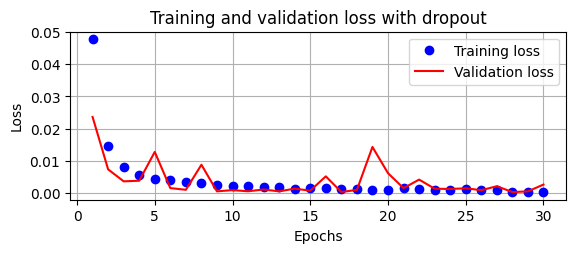

In [24]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
#plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with dropout')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.show()